# Import statements 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from  my_ml_lib import MetricTools, PlotTools

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import json
import datetime
import copy
from PIL import Image as im
import joblib
from sklearn.model_selection import train_test_split
# import math as Math
import random
import torch.optim

In [6]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [7]:
import cv2

# Saving and Loading code 

In [8]:
# Saving and Loading models using joblib 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)


# Importing Dataset 

In [9]:
p = "/content/drive/MyDrive/A3/"
data_path = p + "dataset/train.pkl"
x = load(data_path)

In [10]:
# save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# # saving the images and labels array 
# save(save_path + "data_image.pkl",data_image)
# save(save_path + "data_label.pkl",data_label)
# # dict values where labels key and image arrays as vlaues in form of list 
# save(save_path + "my_dict.pkl",my_dict)

In [11]:
save_path = p + "dataset/"
# saving the images and labels array 
data_image = load(save_path + "data_image.pkl")
data_label = load(save_path + "data_label.pkl")
# dict values where labels key and image arrays as vlaues in form of list 
my_dict = load(save_path + "my_dict.pkl")

In [12]:
len(data_image) , len(data_label), my_dict.keys()

(5000, 5000, dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

# Data Class and Data Loaders and Data transforms 

In [13]:
len(x['names']) ,x['names'][4999] , data_image[0].shape

(5000, 'train05000', (32, 32, 3))

## Splitting the data into train and val

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_image, data_label, test_size=0.10, random_state=42,stratify=data_label )

In [15]:
len(X_train) , len(y_train) , len(X_test) ,len(y_test)

(4500, 4500, 500, 500)

In [16]:
pd.DataFrame(y_test).value_counts() 

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
dtype: int64

## Data Class

In [17]:
train_transforms = transforms.Compose([
                                       transforms.RandomHorizontalFlip(),
])

val_transforms = transforms.Compose([
])

In [18]:
class myDataClass(Dataset):
  """Custom dataset class"""

  def __init__(self, images, labels , transform=None):

    """
    Args:
        images : Array of all the images 
        labels : Correspoing labels of all the images 
    """
    
    self.images = images
    self.labels = labels
    self.transform = transform
    
  def __len__(self):

    return len(self.images)

  def __getitem__(self, idx):
    # converts image value between 0 and 1 and returns a tensor C,H,W 
    img = torchvision.transforms.functional.to_tensor(self.images[idx])
    target = self.labels[idx]
    

    if self.transform:
        img = self.transform(img)
    return img,target 

## Data Loaders 

In [19]:
batch = 64
train_dataset = myDataClass(X_train, y_train,train_transforms)
test_dataset = myDataClass(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= batch, shuffle=True)

In [20]:
# next(iter(train_dataloader))[0].shape

In [21]:
len(train_dataloader) , len(test_dataloader)

(71, 8)

# Train and Test functions 

In [33]:
def load_best(all_models,model_test):
  FILE  = all_models[-1]
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_test.parameters(), lr=0)

  checkpoint = torch.load(FILE)
  model_test.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optim_state'])
  epoch = checkpoint['epoch']
  model_test.eval()

  return model_test


In [34]:
def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name):
  model_no = 1
  c = 1
  all_models = []

  valid_loss_min = np.Inf 
  train_losses = []
  val_losses = []

  for e in range(epochs):

      train_loss = 0.0
      valid_loss = 0.0

      model.train()
      
      for idx, (images,labels) in enumerate(train_dataloader):
        
          images, labels = images.to(device) , labels.to(device) 
    
          optimizer.zero_grad()        
          log_ps= model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
          
          train_loss += ((1 / (idx + 1)) * (loss.data - train_loss))
      else:

          accuracy = 0
          correct = 0
          model.eval()

          with torch.no_grad():
              for idx, (images,labels) in enumerate(test_dataloader):

                  images, labels = images.to(device) , labels.to(device)

                  log_ps = model(images)
                  
                  _, predicted = torch.max(log_ps.data, 1)
                  loss = criterion(log_ps, labels)

                  # correct += (predicted == labels).sum().item()
                  equals = predicted == labels.view(*predicted.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  valid_loss += ((1 / (idx + 1)) * (loss.data - valid_loss))

          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              e+1, 
              train_loss,
              valid_loss
              ), "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloader)))

          train_losses.append(train_loss)
          val_losses.append(valid_loss)

          if valid_loss < valid_loss_min:
            
            print('Saving model..' + str(model_no))
            valid_loss_min = valid_loss

            checkpoint = {
            "epoch": e+1,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": val_losses,
            }

            FILE =  save_path + basic_name +"_epoch_" + str(e+1) + "_model_" +  str(model_no)
            all_models.append(FILE)
            torch.save(checkpoint, FILE)
            model_no = model_no + 1
          
  
  save(save_path + basic_name + "_all_models.pkl", all_models)
  return model, train_losses, val_losses, all_models 
   

In [35]:
def plot(train_losses,val_losses,title='Training Validation Loss with CNN'):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  _ = plt.ylim()
  plt.title(title)
  # plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
  plt.show()

In [36]:
def test(loader, model, criterion, device, name):
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (images, labels) in enumerate(loader):

        # move to GPU or CPU
        images, labels = images.to(device)   , labels.to(device) 
        target = labels

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output,labels)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())


        correct += np.sum(pred.view_as(labels).cpu().numpy() == labels.cpu().numpy())
        total = total + images.size(0)
        # if batch_idx % 20 == 0:
        #     print("done till batch" , batch_idx+1)
            
    print(name + ' Loss: {:.6f}\n'.format(test_loss))

    print(name + ' Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return y, y_hat

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
# def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name)
# def plot(train_losses,val_losses,title='Training Validation Loss with CNN')
# def test(loader, model, criterion, device)

# Relu [ X=2 Y=3 Z=1 ] 

## CNN-Block-123

### model 

In [39]:
cfg3 = {
    'B123': [16,16,'M','D',32,32,32,'M','D',64,'M','D'],
}

In [40]:
def make_layers3(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.AvgPool2d(kernel_size=4, stride=3)]
        elif v == 'D':
            layers += [nn.Dropout(p=0.5)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [41]:
class Model_B123(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B123, self).__init__()
        self.features = features 

        self.classifier = nn.Sequential(
            # nn.Linear(1600, 512),
            # nn.ReLU(True),
            # nn.Linear(512, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 64),
            # nn.ReLU(True),
            nn.Linear(64, 10),
        )
       
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [42]:
# m = Model_B123(make_layers3(cfg3['B123']))
# for i,l in train_dataloader:
#   o = m(i)

In [43]:
model3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 
learning_rate = 0.001
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
print(model3)

Model_B123(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): R

### train 

In [44]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.5)/cnn_block123/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.5)/cnn_block123/'

In [45]:
save_path3 = p + "models_saved_Q1/1_4/colab_notebooks /Batchnorm_and_pooling/models/"

### rough to find out best number of epochs 

In [46]:
m, train_losses, val_losses,m_all_models = train(save_path3,500,train_dataloader,model3,test_dataloader,optimizer3,criterion3,"rough_cnn_b123_x2_y3_z1_with_BN_avg_pool_dp_without_WD_0.001_with_aug")

Epoch: 1 	Training Loss: 1.946812 	Validation Loss: 1.730217 Test Accuracy: 0.402
Saving model..1
Epoch: 2 	Training Loss: 1.630536 	Validation Loss: 1.730621 Test Accuracy: 0.369
Epoch: 3 	Training Loss: 1.511680 	Validation Loss: 1.482165 Test Accuracy: 0.490
Saving model..2
Epoch: 4 	Training Loss: 1.433093 	Validation Loss: 1.416240 Test Accuracy: 0.476
Saving model..3
Epoch: 5 	Training Loss: 1.357044 	Validation Loss: 1.535428 Test Accuracy: 0.436
Epoch: 6 	Training Loss: 1.314446 	Validation Loss: 1.312216 Test Accuracy: 0.526
Saving model..4
Epoch: 7 	Training Loss: 1.276483 	Validation Loss: 2.810998 Test Accuracy: 0.311
Epoch: 8 	Training Loss: 1.234024 	Validation Loss: 1.383263 Test Accuracy: 0.532
Epoch: 9 	Training Loss: 1.189886 	Validation Loss: 1.297385 Test Accuracy: 0.531
Saving model..5
Epoch: 10 	Training Loss: 1.148916 	Validation Loss: 1.379494 Test Accuracy: 0.519
Epoch: 11 	Training Loss: 1.094167 	Validation Loss: 1.365034 Test Accuracy: 0.521
Epoch: 12 	Train

### Tests and Plots 

## select epocs graph for epoch=500

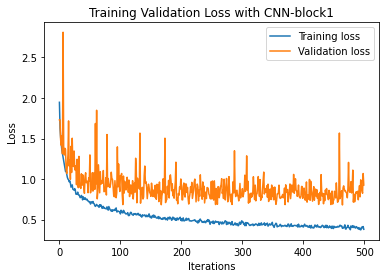

In [47]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [49]:
all_models3 = load(save_path3 + "rough_cnn_b123_x2_y3_z1_with_BN_avg_pool_dp_without_WD_0.001_with_aug_all_models.pkl")
FILE  = all_models3[-1]
m3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 

In [50]:
m3 = load_best(all_models3,m3)

In [51]:
train_y, train_y_hat = test(train_dataloader, m3, criterion3, device, "TRAIN")

TRAIN Loss: 0.207575

TRAIN Accuracy: 92% (4144/4500)


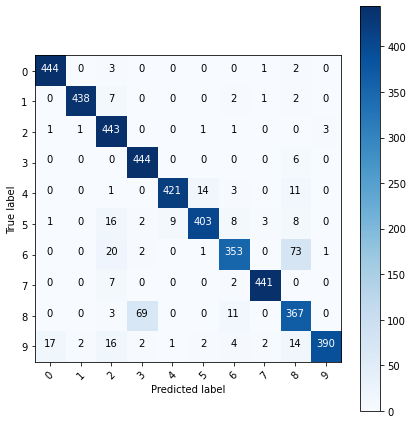

In [52]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [53]:
test_y, test_y_hat = test(test_dataloader, m3, criterion3, device,"TEST")

TEST Loss: 0.683457

TEST Accuracy: 78% (394/500)


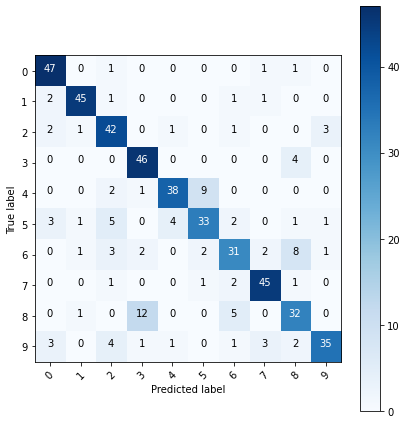

In [54]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))